<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Intro to CNNs and DNNs

## Objectives

* Build and train a deep conv net
* Explore and implement various initialization techniques
* Implement a parameterized module in Pytorch
* Use a principled loss function

## Video Tutorial
[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

## Deliverable
For this lab, you will submit an ipython notebook via learningsuite.
This is where you build your first deep neural network!

For this lab, we'll be combining several different concepts that we've covered during class,
including new layer types, initialization strategies, and an understanding of convolutions.

## Grading Standards:
* 30% Part 0: Successfully followed lab video and typed in code
* 20% Part 1: Re-implement Conv2D and CrossEntropy loss function
* 20% Part 2: Implement different initialization strategies
* 10% Part 3: Print parameters, plot train/test accuracy
* 10% Part 4: Convolution parameters quiz
* 10% Tidy and legible figures, including labeled axes where appropriate
___

### Part 0
Watch and follow video tutorial:

[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

**TODO:**

* Watch tutorial

**DONE:**

In [0]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [0]:
# Use the dataset class you created in lab2
#Create a dataset class that extends the torch.utils.data Dataset class here    
class FashionMNISTProccessedDataset(Dataset):
    def __init__(self, root, train=True):
        self.data = datasets.FashionMNIST(root,
                                          train=train,
                                          transform=transforms.ToTensor(),
                                          download=True)
        
    def __getitem__(self, i):
        x, y = self.data[i]
        #May need to convert y to type tensor
        return x, y
    
    def __len__(self):
        return len(self.data)

0it [00:00, ?it/s]

26427392it [00:04, 5312749.81it/s]                              


Extracting /temp/fashionmist/FashionMNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 36269.51it/s]                           
0it [00:00, ?it/s]

Extracting /temp/fashionmist/FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:02, 1493501.60it/s]                            
0it [00:00, ?it/s]

Extracting /temp/fashionmist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 12583.36it/s]            

Extracting /temp/fashionmist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


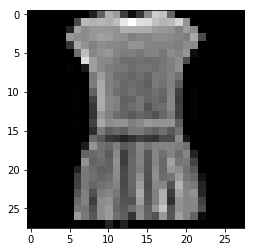

In [4]:
#Explore data
root = '/temp/fashionmist'
train_dataset = FashionMNISTProccessedDataset(root, train=True)
val_dataset = FashionMNISTProccessedDataset(root, train=False)

#Examine a few images by hand
plt.imshow(np.array(train_dataset.data[3][0].squeeze(0)), cmap="gray")

In [0]:
#Look as what classes we have
train_dataset.data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [8]:
val_dataset.data.data.shape
val_dataset.data.targets.shape

torch.Size([10000])

___

### Part 1
Re-implement a Conv2D module with parameters and a CrossEntropy loss function.

**TODO:**

* CrossEntropyLoss 
* Conv2D

**DONE:**

___

### Part 2
Implement a few initialization strategies which can include Xe initialization
(sometimes called Xavier), Orthogonal initialization, and uniform random.
You can specify which strategy you want to use with a parameter. 



Helpful links include:
*  [Orthogonal Initialization](https://hjweide.github.io/orthogonal-initialization-in-convolutional-layers) (or the original paper: http://arxiv.org/abs/1312.6120)
*  http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization

**TODO:**
* Parameterize custom Conv2D for different initilization strategies
* Xe
* Orthogonal
* Uniform

**DONE:**



In [0]:
class CrossEntropyLoss(nn.Module):
    def __init__(self):
        super(CrossEntropyLoss, self).__init__()
        
    def forward(self, output, targets):
        """
        Calculates softmax outputs and cross entropy loss
        
        Parameters:
            input ((batch_size, output_size) torch.tensor): the neural network output
            targets ((batch_size) torch.tensor): the target integer labels
            
        Returns:
            cel ((1) torch.tensor): the average cross entropy loss over the batch
        """
        
        #Compute softmax of input
        b = torch.exp(output)        
        softmax = b/b.sum(1, keepdim=True)
        
        #Get predicted probabilities
        rows = torch.arange(b.size(0))
        cols = targets        
        pred_probs = softmax[rows, cols]
        
        #Calculate cross entropy loss
        cel = -torch.log(pred_probs).mean()
        
        return cel
    
    
def accuracy(output, targets):
    """
    Calculates softmax outputs and cross entropy loss
        
        Parameters:
            input ((batch_size, output_size) torch.tensor): the neural network output
            targets ((batch_size) torch.tensor): the target integer labels
            
        Returns:
            acc (float): the accuracy
    """
    
    #Compute softmax of input
    b = torch.exp(output)        
    softmax = b/b.sum(1, keepdim=True)
    
    #Get predictions
    preds = softmax.argmax(1)
    
    acc = (preds == targets).float().mean()
    
    
    return acc
    

class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', init_mode="Xavier"):
        #Set all parameters as class members
        self.__dict__.update(locals())
        
        #Call parent class init
        super(Conv2d, self).__init__()
        
        self.weight = Parameter(torch.Tensor(self.out_channels, self.in_channels, *kernel_size))
        self.bias = Parameter(torch.Tensor(out_channels))
        
        #Initalize parameters
        if init_mode == "Xavier":
            n_in = np.product(kernel_size)*self.in_channels
            n_out = np.product(kernel_size)*self.out_channels
            mean = 0
            std_dev = np.sqrt(2/(n_in + n_out))
            self.weight.data = torch.from_numpy(np.random.normal(loc=mean, scale=std_dev, size=self.weight.size()).astype(np.float32))
            self.bias.data.uniform_(0, 0)
            
        elif init_mode == "Uniform":
            self.weight.data.uniform_(-1, 1)
            self.bias.data.uniform_(0, 0)
            
        elif init_mode == "Orthogonal":            
            X = np.random.random((self.in_channels, self.out_channels*np.prod(self.kernel_size)))
            _, _, Vt = np.linalg.svd(X, full_matrices=False)
            self.weight.data = torch.from_numpy(Vt.reshape((self.out_channels, self.in_channels, *self.kernel_size)).astype(np.float32))
            self.bias.data.uniform_(0, 0)
        else:
            raise ValueError("init_mode must be one of 'Xavier', 'Uniform', or 'Orthogonal'")
        
    def forward(self, x):
        #See pytorch functionals 
        return F.conv2d(input=x,
                        weight=self.weight,
                        bias=self.bias,
                        stride=self.stride,
                        padding=self.padding,
                        dilation=self.dilation,
                        groups=self.groups)
    
    def extra_repr(self):
        return "String in Conv2d.extra_repr"

In [0]:
class ConvNetwork(nn.Module):
    def __init__(self, dataset):
        super(ConvNetwork, self).__init__()
        x, y = dataset[0]
        c, h, w = x.size()
        output = 10 #There are ten classes
        
        
        self.net = nn.Sequential(Conv2d(in_channels=c,
                                        out_channels=10,
                                        kernel_size=(3, 3),
                                        padding=(1, 1)),
                                 nn.ReLU(),
                                 Conv2d(in_channels=10,
                                        out_channels=20,
                                        kernel_size=(3, 3),
                                        padding=(1, 1)),
                                 nn.ReLU(),
                                 Conv2d(in_channels=20,
                                        out_channels=40,
                                        kernel_size=(3, 3),
                                        padding=(1, 1)),
                                 nn.ReLU(),
                                 Conv2d(in_channels=40,
                                        out_channels=80,
                                        kernel_size=(3, 3),
                                        padding=(1, 1)),
                                 nn.ReLU(),
                                 Conv2d(in_channels=80,
                                        out_channels=120,
                                        kernel_size=(3, 3),
                                        padding=(1, 1)),
                                 nn.ReLU(),
                                 Conv2d(in_channels=120,
                                        out_channels=output,
                                        kernel_size=(28, 28),
                                        padding=(0, 0))
                                )
        
    def forward(self, x):
        return self.net(x).squeeze(2).squeeze(2)


In [0]:
#Initialize Datasets
train_dataset = FashionMNISTProccessedDataset(root, train=True)
val_dataset = FashionMNISTProccessedDataset(root, train=False)

#Initialize DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, pin_memory=True)

#Initialize Model
model = ConvNetwork(train_dataset)
model.cuda() #Put parameters onto GPU

#Initialize Objective and Optimizer and other parameters
objective = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [104]:
#Run your training and validation loop and collect stats
losses = []
val_losses = []
accs = []

for epoch in range(1):
    loop = tqdm(total=len(train_loader), position=0, leave=False)
    
    for batch, (x, y_truth) in enumerate(train_loader):
        x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)
        
        #zero the gradients
        optimizer.zero_grad()
        
        #Get predictions
        y_hat = model(x)
        
        #Calculate objective
        loss = objective(y_hat, y_truth)
        
        #Calculate accuracy
        acc = accuracy(y_hat, y_truth)
        accs.append(acc)
        
        #Calculate gradients
        loss.backward()
        
        losses.append(loss.item())
        loop.set_description("Epoch: {}, loss: {:.4f}, accuracy: {:.3f}".format(epoch, loss.item(), acc))
        loop.update(1)
        
        #Apply gradients
        optimizer.step()
        
        if batch % 500 == 0:
            #Calculate validation loss
            val_loss = np.mean([objective(model(x.cuda()), y.cuda()).item() for x, y in val_loader])
            val_losses.append((len(losses), val_loss)) 
        

Epoch: 0, loss: 0.2961, accuracy: 0.875: 100%|█████████▉| 1874/1875 [00:49<00:00, 42.77it/s]


___

### Part 3
Print the number of parameters in your network and plot accuracy of your training and validation 
set over time. You should experiment with some deep networks and see if you can get a network 
with close to 1,000,000 parameters.

**TODO:**
* Experiment with Deep Networks
* Plot accuracy of training and validation set over time
* Print out number of parameters in the model 

**DONE:**


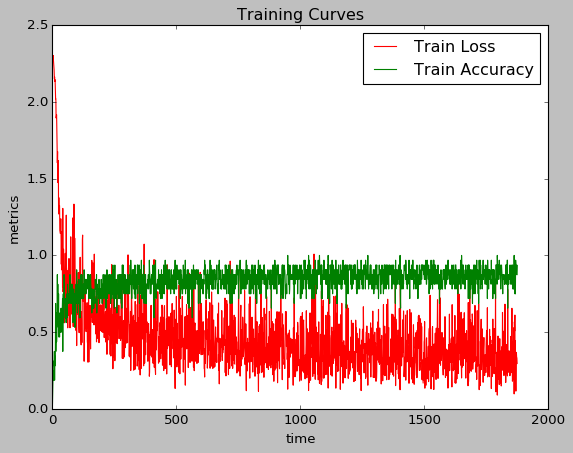

In [105]:
# Go back up and try a few different networks and initialization strategies
# Plot loss if you want
# Plot accuracy
plt.style.use('classic')
plt.plot(losses, color="Red", label="Train Loss")
plt.plot(accs, color="Green", label="Train Accuracy")
plt.legend()
plt.xlabel("time")
plt.ylabel("metrics")
plt.title("Training Curves")
plt.show()

In [106]:
# Compute and print the number of parameters in the model
num_params = np.sum([np.prod((p.size())) for p in model.parameters()])
print(num_params)

1065370


___

### Part 4
Learn about how convolution layers affect the shape of outputs, and answer the following quiz questions. Include these in a new markdown cell in your jupyter notebook.


*Using a Kernel size of 3×3 what should the settings of your 2d convolution be that results in the following mappings (first answer given to you)*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : (out_channels=22, kernel_size=(3, 3), padding=(1, 1))
* (c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : (out_channels=65, kernel_size=(3, 3), padding=(2, 2))
* (c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : (out_channels=7, kernel_size=(3, 3), padding=(6, 6))

*Using a Kernel size of 5×5:*)

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : (out_channels=100, kernel_size=(5, 5), padding=(2, 2))
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : (out_channels=23, kernel_size=(5, 5), padding=(3, 3))
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) :  (out_channels=5, kernel_size=(5, 5), padding=(9, 9))

*Using Kernel size of 5×3:*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) :  (out_channels=10, kernel_size=(5, 3), padding=(1, 0))
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : (out_channels=100, kernel_size=(5, 3), padding=(2, 1))
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : (out_channels=23, kernel_size=(5, 3), padding=(3, 2))
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : (out_channels=5, kernel_size=(5, 3), padding=(9, 8))

*Determine the kernel that requires the smallest padding size to make the following mappings possible:*

* (c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : (out_channels=10, kernel_size=(2, 4), padding=(0, 0))

If we allow 1x1 kernels the answer is
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : (out_channels=22, kernel_size=(1, 1), padding=(0, 0))

However, it should be noted that 1x1 kernels defeats the purpose of using convolutional layers, since all spatial relationships are lost

If we do not allow 1x1 kernels, the answer is

(c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : (out_channels=22, kernel_size=(3, 3), padding=(1, 1))


**TODO:**

* Answer all the questions above 

**DONE:**


In [0]:
# Write some test code for checking the answers for these problems (example shown in the video)
c = nn.Conv2d(3, 22, kernel_size=(3, 3), padding=(1, 1))
c(torch.zeros(1, 3, 10, 10)).size()

torch.Size([1, 22, 10, 10])